# Preamble

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
# import imageio_ffmpeg
import pandas as pd
import seaborn as sns

# %load_ext autoreload
# %autoreload 2

from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_2d_square, create_2d_square_structured
from scipy.integrate import solve_ivp
from solver import get_n_element_operators, AdvectionIVPSolver2D

from utils import u_exact_hill, u_exact_hill_dt, f_rhs_hill, advection_velocity_field, get_boundary_normal

In [2]:
sns.set_theme(style="whitegrid", context="paper")

# Solver

In [3]:
# Solver parameters
N = 5  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.75, -0.25
SIGMA = 0.1

t_start = 0.0
t_final = 5.0

Info    : Meshing 1D...
Info    : Meshing curve 1 (Circle)
Info    : Done meshing 1D (Wall 7.24159e-05s, CPU 0.0001s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0039475s, CPU 0.0041s)
Info    : 72 nodes 143 elements
Total DOFs: 1546


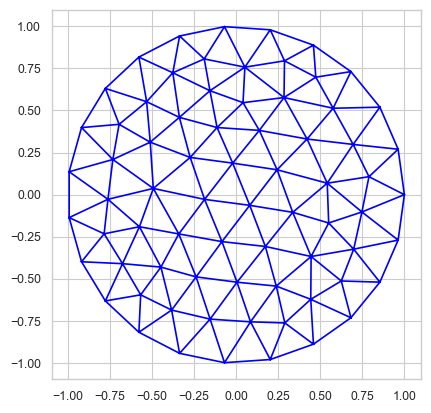

In [4]:
mesh_circle = create_2d_circle(radius=DOMAIN_RADIUS, origin=DOMAIN_ORIGIN, mesh_size=MESH_SIZE)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh_circle, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")

mesh_circle.plot()

In [5]:
solver = AdvectionIVPSolver2D(
    mesh=mesh_circle,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
    with_upwind_scheme=True,
)

Assembling global matrices...


  0%|          | 0/119 [00:00<?, ?it/s]/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_3/solver.py:89: RuntimeWarning: divide by zero encountered in matmul
  MAx = np.diag(ax) @ M @ Dx
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_3/solver.py:89: RuntimeWarning: overflow encountered in matmul
  MAx = np.diag(ax) @ M @ Dx
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_3/solver.py:89: RuntimeWarning: invalid value encountered in matmul
  MAx = np.diag(ax) @ M @ Dx
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_3/solver.py:90: RuntimeWarning: divide by zero encountered in matmul
  MAy = np.diag(ay) @ M @ Dy
/Users/tymoteuszbarcinski/DTU/2_autum_2025/02689/02689-Advanced-Numerical-Methods/assignment_3/solver.py:90: RuntimeWarning: overflow encountered in matmul
  MAy = np.diag(ay) @ M @ Dy
/Users/tymoteuszbar

In [6]:
# Set up initial condition
u0 = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0)

t_span = (t_start, t_final, )
n_frames = 300
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    rtol=1e-8,  # Relative tolerance
    atol=1e-11,  # Absolute tolerance
    # max_step=0.0001,  # Limit max step size for accuracy
)

u_sols, t_sols = sol.y.T, sol.t
print(sol.nfev)

36332


# Results

Computing Error...
L2 Error at t=5.0: 1.85e-02


/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_38030/4212589453.py:6: RuntimeWarning: divide by zero encountered in matmul
  L2_err = np.sqrt(error @ (solver.M_global @ error))
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_38030/4212589453.py:6: RuntimeWarning: overflow encountered in matmul
  L2_err = np.sqrt(error @ (solver.M_global @ error))
/var/folders/js/8yl2n_yn68z6z55b5359_fwm0000gn/T/ipykernel_38030/4212589453.py:6: RuntimeWarning: invalid value encountered in matmul
  L2_err = np.sqrt(error @ (solver.M_global @ error))


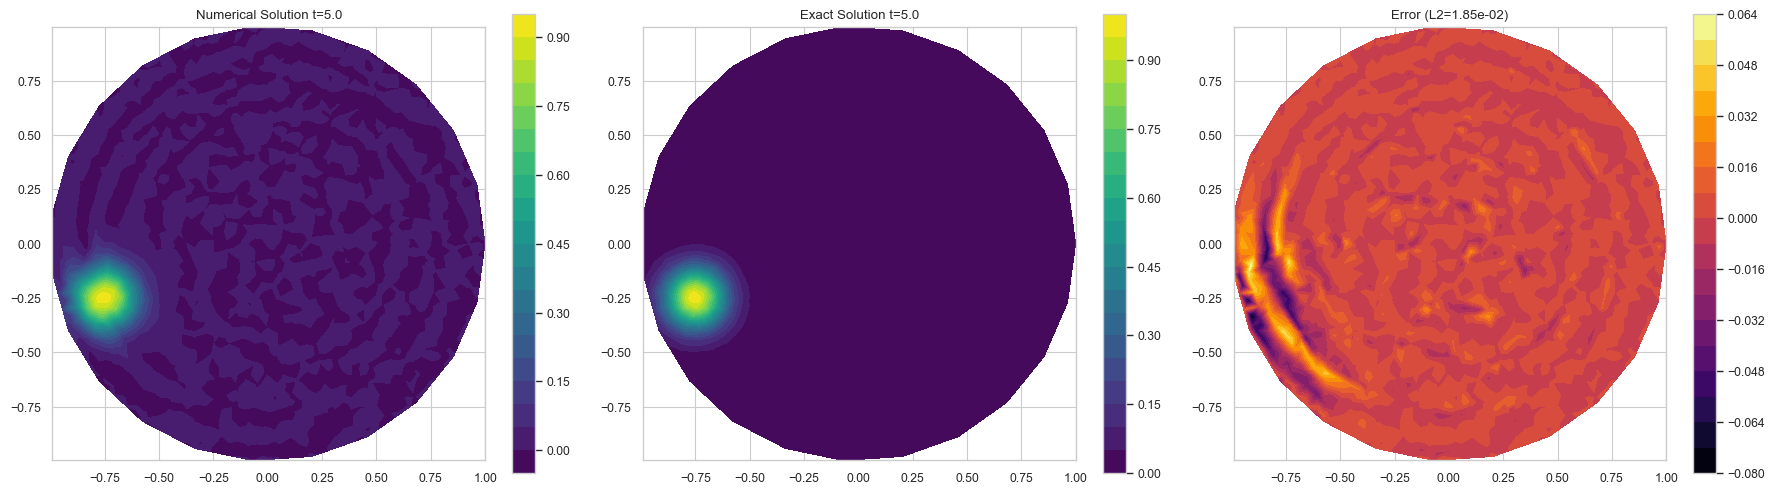

In [7]:
# Compute Error
print("Computing Error...")
final_sol = u_sols[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
print(f"L2 Error at t={t_final}: {L2_err:.2e}")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Triangulation for plotting
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

# Solution
tc1 = axs[0].tricontourf(triang, final_sol, levels=20, cmap="viridis")
fig.colorbar(tc1, ax=axs[0])
axs[0].set_title(f"Numerical Solution t={t_final}")
axs[0].set_aspect("equal")

# Exact
tc2 = axs[1].tricontourf(triang, exact_sol, levels=20, cmap="viridis")
fig.colorbar(tc2, ax=axs[1])
axs[1].set_title(f"Exact Solution t={t_final}")
axs[1].set_aspect("equal")

# Error
tc3 = axs[2].tricontourf(triang, error, levels=20, cmap="inferno")
fig.colorbar(tc3, ax=axs[2])
axs[2].set_title(f"Error (L2={L2_err:.2e})")
axs[2].set_aspect("equal")

plt.tight_layout()
# plt.savefig("solution_plot.png")
# print("Plot saved.")

<Axes: xlabel='time', ylabel='energy'>

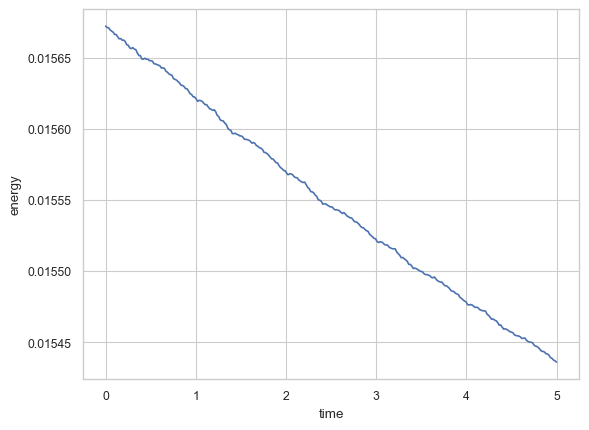

In [8]:
data = []
# Compute energy over time
for u, t in zip(u_sols, t_sols):
    energy = 0.5 * (u @ (solver.M_global @ u))
    data.append({
        "energy": energy,
        "time": t
    })
df = pd.DataFrame(data)

# Plot energy
plt.figure()
sns.lineplot(data=df, x="time", y="energy")

# Convergence